# Ibis.MapD Geo Spatial Data Types and Functions

In [1]:
import pymapd
import os

In [2]:
conn_info = dict(
    host='metis.mapd.com', port='443', 
    user='mapd', password='HyperInteractive', 
    dbname='ibis_testing', protocol='https'
)
os.environ['IBIS_TEST_OMNISCI_HOST'] = conn_info['host']
os.environ['IBIS_TEST_OMNISCI_PORT'] = conn_info['port']
os.environ['IBIS_TEST_OMNISCI_USER'] = conn_info['user']
os.environ['IBIS_TEST_OMNISCI_PASSWORD'] = conn_info['password']
os.environ['IBIS_TEST_OMNISCI_DATABASE'] = conn_info['dbname']
os.environ['IBIS_TEST_OMNISCI_PROTOCOL'] = conn_info['protocol']

In [4]:
!git clone https://github.com/ibis-project/ibis /tmp/ibis --depth=1
!cp $HOME/dev/quansight/ibis-project/ibis/ci/datamgr.py /tmp/ibis/ci/
!cd /tmp/ibis/ci && \
python datamgr.py download && \
python datamgr.py omnisci \
  --host ${IBIS_TEST_OMNISCI_HOST} \
  --port ${IBIS_TEST_OMNISCI_PORT} \
  --user ${IBIS_TEST_OMNISCI_USER} \
  --password ${IBIS_TEST_OMNISCI_PASSWORD} \
  --database ${IBIS_TEST_OMNISCI_DATABASE} \
  --protocol ${IBIS_TEST_OMNISCI_PROTOCOL}

fatal: la ruta de destino '/tmp/ibis' ya existe y no es un directorio vacío.
  3163 datamgr              INFO     MainThread                Downloading https://github.com/ibis-project/testing-data/archive/master.zip to /tmp/ibis/ci/ibis-testing-data.zip...
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   130    0   130    0     0    211      0 --:--:-- --:--:-- --:--:--   210
100  268M    0  268M    0     0  1520k      0 --:--:--  0:03:00 --:--:-- 1270k
184394 datamgr              INFO     MainThread                Extracting archive to /tmp/ibis/ci/ibis-testing-data
  2809 datamgr              INFO     MainThread                Initializing OmniSci...


In [5]:
conn = pymapd.connect(**conn_info)

In [6]:
conn.get_tables()

['diamonds', 'batting', 'awards_players', 'functional_alltypes', 'geo']

In [7]:
t_name = 'geo'

In [8]:
conn.get_table_details(t_name)

[ColumnDetails(name='id', type='INT', nullable=True, precision=0, scale=0, comp_param=0, encoding='NONE'),
 ColumnDetails(name='geo_point', type='POINT', nullable=True, precision=23, scale=0, comp_param=0, encoding='NONE'),
 ColumnDetails(name='geo_linestring', type='LINESTRING', nullable=True, precision=23, scale=0, comp_param=0, encoding='NONE'),
 ColumnDetails(name='geo_polygon', type='POLYGON', nullable=True, precision=23, scale=0, comp_param=0, encoding='NONE'),
 ColumnDetails(name='geo_multipolygon', type='MULTIPOLYGON', nullable=True, precision=23, scale=0, comp_param=0, encoding='NONE')]

In [9]:
import ibis

In [10]:
ibis_conn_info = conn_info.copy()
ibis_conn_info['database'] = ibis_conn_info['dbname']
del ibis_conn_info['dbname']

ibis_conn = ibis.mapd.connect(**ibis_conn_info)

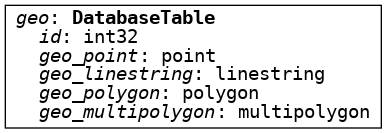

In [11]:
t = ibis_conn.table(t_name)
t

In [16]:
print(t[t.geo_multipolygon.area().name('area')].head(1).execute())

   area
0   0.0


In [17]:
print(t[t.geo_polygon.perimeter().name('perimeter')].head(1).execute())

   perimeter
0   5.656854


In [18]:
linestring1 = ibis.literal([(0, 1), (2, 3)], type="linestring")
expr = t[[t, linestring1.length().name('length')]]
print(expr.head().compile())
expr.head().execute()

SELECT *, ST_LENGTH('LINESTRING(0 1, 2 3)') AS length
FROM geo
LIMIT 5


,id,geo_point,geo_linestring,geo_polygon,geo_multipolygon,rowid,length
0,1,POINT (0 0),"LINESTRING (0 0,1 1)","POLYGON ((0 0,1 1,2 2,0 0),(1 1,3 3,2 2,1 1))","MULTIPOLYGON (((0 0,1 1,2 2,0 0),(1 1,3 3,2 2,...",0,2.828427
1,2,POINT (1 1),"LINESTRING (1 1,2 2)","POLYGON ((1 1,2 2,3 3,1 1),(2 2,4 4,3 3,2 2))","MULTIPOLYGON (((1 1,2 2,3 3,1 1),(2 2,4 4,3 3,...",1,2.828427
2,3,POINT (2 2),"LINESTRING (2 2,3 3)","POLYGON ((2 2,3 3,4 4,2 2),(3 3,5 5,4 4,3 3))","MULTIPOLYGON (((2 2,3 3,4 4,2 2),(3 3,5 5,4 4,...",2,2.828427
3,4,POINT (3 3),"LINESTRING (3 3,4 4)","POLYGON ((3 3,4 4,5 5,3 3),(4 4,6 6,5 5,4 4))","MULTIPOLYGON (((3 3,4 4,5 5,3 3),(4 4,6 6,5 5,...",3,2.828427
4,5,POINT (4 4),"LINESTRING (4 4,5 5)","POLYGON ((4 4,5 5,6 6,4 4),(5 5,7 7,6 6,5 5))","MULTIPOLYGON (((4 4,5 5,6 6,4 4),(5 5,7 7,6 6,...",4,2.828427


In [19]:
linestring1 = ibis.literal([(0, 1), (2, 3)], type="linestring")
point1 = ibis.literal((0, 0), type="point")

expr = t[[t, linestring1.distance(point1).name('distance')]]
print(expr.head().compile())
expr.head().execute()

SELECT *, ST_DISTANCE('LINESTRING(0 1, 2 3)', 'POINT(0 0)') AS distance
FROM geo
LIMIT 5


,id,geo_point,geo_linestring,geo_polygon,geo_multipolygon,rowid,distance
0,1,POINT (0 0),"LINESTRING (0 0,1 1)","POLYGON ((0 0,1 1,2 2,0 0),(1 1,3 3,2 2,1 1))","MULTIPOLYGON (((0 0,1 1,2 2,0 0),(1 1,3 3,2 2,...",0,1.0
1,2,POINT (1 1),"LINESTRING (1 1,2 2)","POLYGON ((1 1,2 2,3 3,1 1),(2 2,4 4,3 3,2 2))","MULTIPOLYGON (((1 1,2 2,3 3,1 1),(2 2,4 4,3 3,...",1,1.0
2,3,POINT (2 2),"LINESTRING (2 2,3 3)","POLYGON ((2 2,3 3,4 4,2 2),(3 3,5 5,4 4,3 3))","MULTIPOLYGON (((2 2,3 3,4 4,2 2),(3 3,5 5,4 4,...",2,1.0
3,4,POINT (3 3),"LINESTRING (3 3,4 4)","POLYGON ((3 3,4 4,5 5,3 3),(4 4,6 6,5 5,4 4))","MULTIPOLYGON (((3 3,4 4,5 5,3 3),(4 4,6 6,5 5,...",3,1.0
4,5,POINT (4 4),"LINESTRING (4 4,5 5)","POLYGON ((4 4,5 5,6 6,4 4),(5 5,7 7,6 6,5 5))","MULTIPOLYGON (((4 4,5 5,6 6,4 4),(5 5,7 7,6 6,...",4,1.0


In [21]:
# 

point1 = ibis.literal((0, 0), type="point;4326:geometry")
expr = t[[t, t.geo_multipolygon.contains(point1).name('contained')]]


print(expr.head().compile())
expr.head().execute()

SELECT *,
       ST_CONTAINS("geo_multipolygon", ST_GeomFromText('POINT(0 0)', 4326)) AS contained
FROM geo
LIMIT 5


,id,geo_point,geo_linestring,geo_polygon,geo_multipolygon,rowid,contained
0,1,POINT (0 0),"LINESTRING (0 0,1 1)","POLYGON ((0 0,1 1,2 2,0 0),(1 1,3 3,2 2,1 1))","MULTIPOLYGON (((0 0,1 1,2 2,0 0),(1 1,3 3,2 2,...",0,True
1,2,POINT (1 1),"LINESTRING (1 1,2 2)","POLYGON ((1 1,2 2,3 3,1 1),(2 2,4 4,3 3,2 2))","MULTIPOLYGON (((1 1,2 2,3 3,1 1),(2 2,4 4,3 3,...",1,False
2,3,POINT (2 2),"LINESTRING (2 2,3 3)","POLYGON ((2 2,3 3,4 4,2 2),(3 3,5 5,4 4,3 3))","MULTIPOLYGON (((2 2,3 3,4 4,2 2),(3 3,5 5,4 4,...",2,False
3,4,POINT (3 3),"LINESTRING (3 3,4 4)","POLYGON ((3 3,4 4,5 5,3 3),(4 4,6 6,5 5,4 4))","MULTIPOLYGON (((3 3,4 4,5 5,3 3),(4 4,6 6,5 5,...",3,False
4,5,POINT (4 4),"LINESTRING (4 4,5 5)","POLYGON ((4 4,5 5,6 6,4 4),(5 5,7 7,6 6,5 5))","MULTIPOLYGON (((4 4,5 5,6 6,4 4),(5 5,7 7,6 6,...",4,False


In [22]:
fs_points = [
    'x',
    'y',
    'srid'
]

point1 = ibis.literal((0, 0), type="point;4326:geometry")

for f in fs_points:
    d = getattr(point1, f)
    expr = t[[t, d().name('tmp')]]
    print('=' * 80)
    print(expr.head().compile())
    expr.head().execute()

SELECT *, ST_X(ST_GeomFromText('POINT(0 0)', 4326)) AS tmp
FROM geo
LIMIT 5
SELECT *, ST_Y(ST_GeomFromText('POINT(0 0)', 4326)) AS tmp
FROM geo
LIMIT 5
SELECT *, ST_SRID(ST_GeomFromText('POINT(0 0)', 4326)) AS tmp
FROM geo
LIMIT 5


In [23]:
fs_lines = [
    'x_min',
    'x_max',
    'y_min',
    'y_max',
    # 'start_point',  # Function ST_StartPoint not supported
    # 'end_point',  # Function ST_EndPoint not supported
    'n_points',
    'srid'
]

linestring1 = ibis.literal([(0, 1), (2, 3)], type="linestring;4326:geometry")

for f in fs_lines:
    d = getattr(linestring1, f)
    expr = t[[t, d().name('tmp')]]
    print('=' * 80)
    print(expr.head().compile())
    expr.head().execute()

SELECT *, ST_XMIN(ST_GeomFromText('LINESTRING(0 1, 2 3)', 4326)) AS tmp
FROM geo
LIMIT 5
SELECT *, ST_XMAX(ST_GeomFromText('LINESTRING(0 1, 2 3)', 4326)) AS tmp
FROM geo
LIMIT 5
SELECT *, ST_YMIN(ST_GeomFromText('LINESTRING(0 1, 2 3)', 4326)) AS tmp
FROM geo
LIMIT 5
SELECT *, ST_YMAX(ST_GeomFromText('LINESTRING(0 1, 2 3)', 4326)) AS tmp
FROM geo
LIMIT 5
SELECT *, ST_NPOINTS(ST_GeomFromText('LINESTRING(0 1, 2 3)', 4326)) AS tmp
FROM geo
LIMIT 5
SELECT *, ST_SRID(ST_GeomFromText('LINESTRING(0 1, 2 3)', 4326)) AS tmp
FROM geo
LIMIT 5


In [24]:
fs_polygons = [
    'n_rings',
]

polygon = [
    ((0, 0), (4, 0), (4, 4), (0, 4), (0, 0)),
    ((1, 1), (2, 1), (2, 2), (1, 2), (1, 1))
]

polygon1 = ibis.literal(polygon, type="polygon;4326:geometry")

for f in fs_polygons:
    d = getattr(polygon1, f)
    expr = t[[t, d().name('tmp')]]
    print('=' * 80)
    print(expr.head().compile())
    expr.head().execute()

SELECT *,
       ST_NRINGS(ST_GeomFromText('POLYGON((0 0, 4 0, 4 4, 0 4, 0 0), (1 1, 2 1, 2 2, 1 2, 1 1))', 4326)) AS tmp
FROM geo
LIMIT 5


In [25]:
fs = [
    ('max_distance', point1),
    # ('point_n', 1)  # Function ST_PointN not supported
]

linestring1 = ibis.literal([(0, 1), (2, 3)], type="linestring;4326:geometry")

for f, arg in fs:
    d = getattr(linestring1, f)
    expr = t[[t, d(arg).name('tmp')]]
    print('=' * 80)
    print(expr.head().compile())
    expr.head().execute()

SELECT *,
       ST_MAXDISTANCE(ST_GeomFromText('LINESTRING(0 1, 2 3)', 4326), ST_GeomFromText('POINT(0 0)', 4326)) AS tmp
FROM geo
LIMIT 5
